In [41]:
# step size
# Makes report plot
# improt and define basic params
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from pathlib import Path
from os import listdir, path, makedirs
sns.set(style="darkgrid")

mpl.rcParams["savefig.dpi"] = 200
# Calibrated data dir
calibrated_base_dir = Path("..")/"../new_calibrate_full/"
uncalibrated_base_dir = Path("..")/"../uncalibrated_data/"
calibration_curve_base_dir = Path("..")/"../calibration_curve/"
calibrated_table_dir = Path("..")/"../tables/"
uncalibrated_table_dir = Path("..")/"../uncalibrated_tables/"

# Class to use
import sys
sys.path.append("../../python")
from auditing_setup.election_setting import Election

from matplotlib import rc, rc_params
mpl.use('pdf')
plt.rc('font', family='serif', serif='Times')
plt.rc('xtick', labelsize=8)
plt.rc('ytick', labelsize=8)
plt.rc('axes', labelsize=8)
mpl.rcParams["savefig.dpi"] = 200
sns.set(style="darkgrid")
sns.set(font_scale=1.2)
def toggle_tex(to=None):
    if to is not None:
        rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
        rc('text', usetex=to)
    elif mpl.rcParams['text.usetex']:
        rc('text', usetex=False)
    else:
        rc('text', usetex=True)
        
toggle_tex(to=False)

%matplotlib inline

In [69]:
legend_order = ['bravo    | p=0.7 ',
                'bravo    | p=0.55 ',
                'bravo    | p=0.52 ',
                'bravo    | p=0.51 ',
                'bravo_without_replacement | p=0.7 ',
                'bravo_without_replacement | p=0.55 ',
                'bravo_without_replacement | p=0.52 ',
                'bravo_without_replacement | p=0.51 ',
                'bayesian | a=1 | b=1 ',
                'bayesian_with_replacement | a=1 | b=1 ',
                'truncated_bayesian | a=1 | b=1 ',
                'clip     ', 
                'max_sprt ']

def get_position(name):
    for i, legend_pattern in enumerate(legend_order):
        if name.lower().startswith(legend_pattern):
            return i
    else:
        assert False

def reorder_df(df):
    return df.loc[sorted(df.index, key=get_position)]

mpl.rcParams["figure.figsize"] = [8, 6]

def read_csv(file_path, reorder=True):
    df = pd.read_csv(file_path)
    cols = []
    for i in df.columns:
        try:
            cols.append(float(i))
        except Exception as e:
            cols.append(i)
    df.columns = cols
    df.set_index('legend', inplace=True)
    if reorder:
        df = reorder_df(df)
    return df.reset_index()

def get_num_cols(df):
    cols = []
    for i in df.columns:
        try:
            float(i)
            cols.append(float(i))
        except Exception as e:
            pass
    return cols

def format_legend(ax=None, legend=None, how=0):
    if ax is not None:
        legend_ = ax.legend_
    elif legend is not None:
        legend_ = legend
    else:
        return
    
    for text in legend_.texts:
        if how == 0:
            raw = text.get_text()
            text.set_text(raw.replace(" | ", ", ").replace(" ", "").rsplit(",", 1)[0])
        elif how == 1:
            raw = text.get_text()
            print(raw.rsplit(",", 1)[0].replace("_", " "))
            text.set_text(raw.rsplit(",", 1)[0].replace("_", " "))
    return legend_

def make_legend(df, ax, outside=False, *args, **kwargs):
    if outside:
        ax.legend(labels=[basename+" "+(parameter if 'p=' not in parameter else parameter.replace('p=','$p_1$='))+" "+"batch={}".format(step) for i, (basename, parameter, step) in 
                          df[['basename_with_type', 'parameter', 'election_step']].drop_duplicates()
                          .iterrows()],
                 bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,
                 *args, **kwargs)
    else:
        ax.legend(labels=[basename+" "+(parameter if 'p=' not in parameter else parameter.replace('p=','$p_1$='))+" "+"batch={}".format(step) for i, (basename, parameter, step) in 
                          df[['basename_with_type', 'parameter', 'election_step']].drop_duplicates()
                          .iterrows()], *args, **kwargs)

In [45]:
def pivot_widetable(df, names, groupers, *args, **kwargs):
    df_long = df.melt(*args, **kwargs)
    for name, grouper in zip(names, groupers):
        group = [grouper(i) for i in df_long['variable']]
        df_long[name] = group
    return df_long

names = [
    'type'
    'basename'
    'basename_with_type'
    'parameter'
    'parameter_with_type'
]

basename_map = {'bayesian ': 'Bayesian',
                'max_sprt ': 'MaxBRAVO',
                'bravo    ': 'BRAVO',
                'clip     ': 'ClipAuditAudit',
                'bravo_without_replacement ': 'BRAVO',
                'truncated_bayesian ': 'Bayesian (Least Favourable)',
                'bayesian_with_replacement ': 'Bayesian'}

type_map = {'bayesian ': 'Uniform',
            'max_sprt ': '',
            'bravo    ': 'Binomial',
            'clip     ': '',
            'bravo_without_replacement ': 'Hypergeometric',
            'truncated_bayesian ': '',
            'bayesian_with_replacement ': 'Beta'}

basename_map_with_type = {'bayesian ': 'Bayesian (Uniform)',
                          'max_sprt ': 'MaxBRAVO',
                          'bravo    ': 'BRAVO (Binomial)',
                          'clip     ': 'ClipAuditAudit',
                          'bravo_without_replacement ': 'BRAVO',
                          'truncated_bayesian ': 'Bayesian (Least Favourable)',
                          'bayesian_with_replacement ': 'Bayesian (Beta)'}

def group_basename(name):
    name = name.split('|')[0]
    return basename_map[name]

def group_type(name):
    name = name.split('|')[0]
    return type_map[name]

def group_basename_with_type(name):
    name = name.split('|')[0]
    return basename_map_with_type[name]

def group_parameter(name):
    _, name = name.split('|', 1)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return name

def group_parameter_with_type(name):
    _, name = name.split('|', 1)
    type = group_type(_)
    name = name.rsplit('|', 1)[0] if len(name.rsplit('|', 1)) > 1 else ''
    name = name.replace('|', ',')
    name = name.replace(' ', '')
    return type+' '+name
    
groupers = [
    group_type,
    group_basename,
    group_basename_with_type,
    group_parameter,
    group_parameter_with_type
]

filled_markers = (
    'o', 'v', '^', 
    
    '<', '>', '*', 
    
    's', '8', 
    
    'H', 
    
    'D', 
    
    'X')
dash_styles = [
    "",
    (4, 1.5),
    (1, 1),
    
    "",
    (4, 1.5),
    (1, 1),
    
    "",
    (5, 1, 1, 1),
    
    (2, 2, 3, 1.5),
    (1, 2.5, 3, 1.2),
    (5, 1, 2, 1, 2, 1),
]

In [46]:
def prep_long_df(df):
    if 'legend' not in df.columns:
        df = df.reset_index()
    data_long = pivot_widetable(df, [], [], id_vars='legend', var_name='p')
    types = data_long.legend.apply(group_type)
    basenames = data_long.legend.apply(group_basename)
    parameters = data_long.legend.apply(group_parameter)
    basenames_with_type = data_long.legend.apply(group_basename_with_type)
    parameters_with_type = data_long.legend.apply(group_parameter_with_type)
    data_long['type'] = types
    data_long['basename'] = basenames
    data_long['basename_with_type'] = basenames_with_type
    data_long['parameter'] = parameters
    data_long['parameter_with_type'] = parameters_with_type
    data_long['fullname'] = basenames_with_type + ' ' + parameters
    return data_long

In [47]:
def get_data(elections, data_type, query='(basename=="BRAVO" and parameter=="p=0.55" and type=="Hypergeometric") or'
                                                  '(basename=="Bayesian" and type=="BetaBinomial")'):
    all_data_long_dict = {}
    for election in elections:
        data_path = calibrated_table_dir/str(election)/data_type
        data_long = prep_long_df(read_csv(data_path))
        all_data_long_dict[election] = data_long

    _filtered_data_long = []
    for election in all_data_long_dict:
        data = all_data_long_dict[election].query(query)
        data.loc[:, 'election_n'] = election.n
        data.loc[:, 'election_m'] = election.m
        data.loc[:, 'election_replacement'] = election.replacement
        data.loc[:, 'election_step'] = election.step
        _filtered_data_long.append(data)
    filtered_data_long = pd.concat(_filtered_data_long, ignore_index=True)
    filtered_data_long = reorder_df(filtered_data_long.set_index('legend')).reset_index()
    return filtered_data_long

In [ ]:
# 1. Basic 5000/500 plot without replacement

fig = plt.figure(figsize=[9, 12])

ax = fig.add_subplot(311)
elections = [Election(5000, 500, 0.5, s) for s in [1, 20, 50, 250, 500]]
data_type = "power.csv"
data = get_data(elections, data_type)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'fullname',
    size = 'election_step',
    style= 'election_step',
    data=data,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")

make_legend(data, ax, bbox_to_anchor=(0.58, 0.1), loc=2, borderaxespad=0.)

ax = fig.add_subplot(312)
data_type = "unconditional_mean.csv"
data = get_data(elections, data_type)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'fullname',
    size = 'election_step',
    style= 'election_step',
    data=data,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_ylabel("Mean sample size")

ax.set_zorder(-1)

ax = fig.add_subplot(313)
data_type = "unconditional_mean_with_recount.csv"
data = get_data(elections, data_type)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'fullname',
    size = 'election_step',
    style= 'election_step',
    data=data,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_xlabel("True Proportion for winner $p$ ($p$) ($p$)($p$)")
ax.set_ylabel("Mean sample size with recount")

ax.set_zorder(-1)

/Users/Dovermore/.conda/envs/audit_analysis/lib/python3.7/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = _infer_fill_value(value)
/Users/Dovermore/.conda/envs/audit_analysis/lib/python3.7/site-packages/pandas/core/indexing.py:480: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


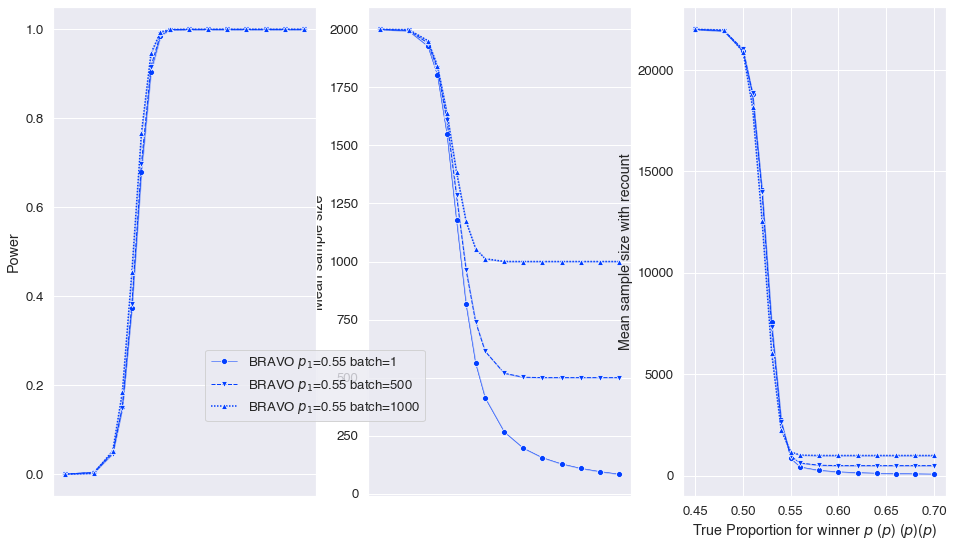

In [77]:
# 1. Basic 20000/2000 plot without replacement

fig = plt.figure(figsize=[16, 9])

ax = fig.add_subplot(131)
elections = [Election(20000, 2000, 0.5, s) for s in [1, 500, 1000]]
data_type = "power.csv"
data = get_data(elections, data_type)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'fullname',
    size = 'election_step',
    style= 'election_step',
    data=data,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_ylabel("Power")

make_legend(data, ax, bbox_to_anchor=(0.58, 0.3), loc=2, borderaxespad=0.)

ax = fig.add_subplot(132)
data_type = "unconditional_mean.csv"
data = get_data(elections, data_type)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'fullname',
    size = 'election_step',
    style= 'election_step',
    data=data,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.xaxis.set_visible(False)
ax.set_ylabel("Mean sample size")

ax.set_zorder(-1)

ax = fig.add_subplot(133)
data_type = "unconditional_mean_with_recount.csv"
data = get_data(elections, data_type)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'fullname',
    size = 'election_step',
    style= 'election_step',
    data=data,
    markers=filled_markers, 
    dashes=dash_styles,
    palette='bright', 
    legend=False, 
    sizes=(0.5, 1.5),
    ax=ax)
ax.set_xlabel("True Proportion for winner $p$ ($p$) ($p$)($p$)")
ax.set_ylabel("Mean sample size with recount")

ax.set_zorder(-1)

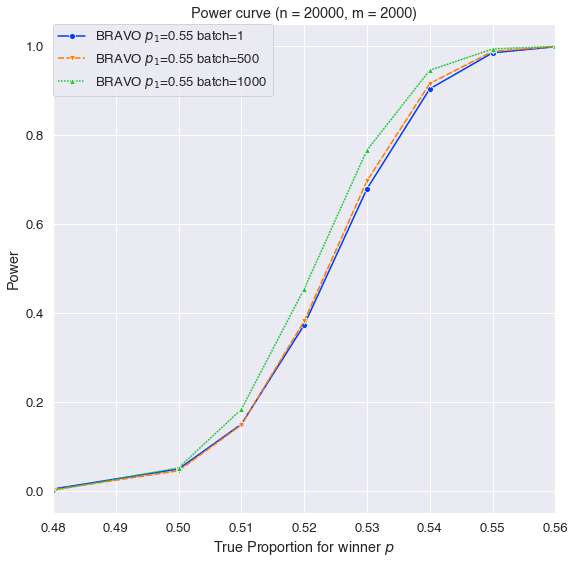

In [78]:
data_type = "power.csv"
data = get_data(elections, data_type)
fig = plt.figure(figsize=[9, 9])
ax = fig.add_subplot(111)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'election_step',
    style= 'election_step',
    data=data,
    markers=filled_markers, 
    dashes=dash_styles,
    palette=sns.color_palette('bright', len(elections)), 
    legend=False, 
    ax=ax)
ax.set_title('Power curve (n = 20000, m = 2000)')
ax.set_xlabel("True Proportion for winner $p$")
ax.set_ylabel("Power")
ax.set_xlim(0.48, 0.56)
make_legend(data, ax, borderaxespad=0.)

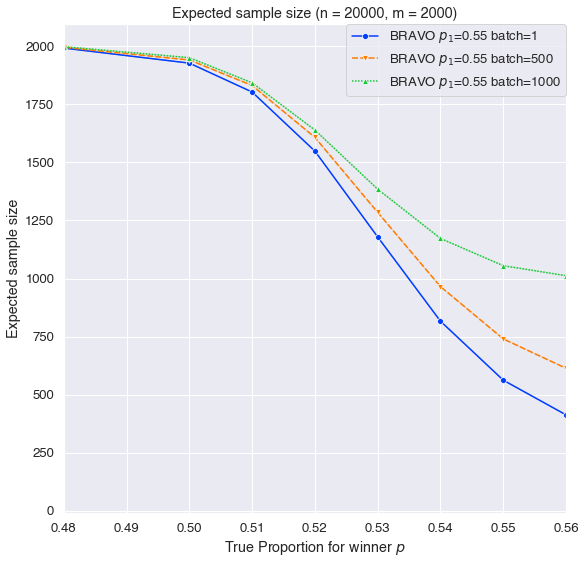

In [79]:
data_type = "unconditional_mean.csv"
data = get_data(elections, data_type)
fig = plt.figure(figsize=[9, 9])
ax = fig.add_subplot(111)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'election_step',
    style= 'election_step',
    data=data,
    markers=filled_markers, 
    dashes=dash_styles,
    palette=sns.color_palette('bright', len(elections)), 
    legend=False, 
    ax=ax)
ax.set_title('Expected sample size (n = 20000, m = 2000)')
ax.set_xlabel("True Proportion for winner $p$")
ax.set_ylabel("Expected sample size")
ax.set_xlim(0.48, 0.56)
make_legend(data, ax, borderaxespad=0.)

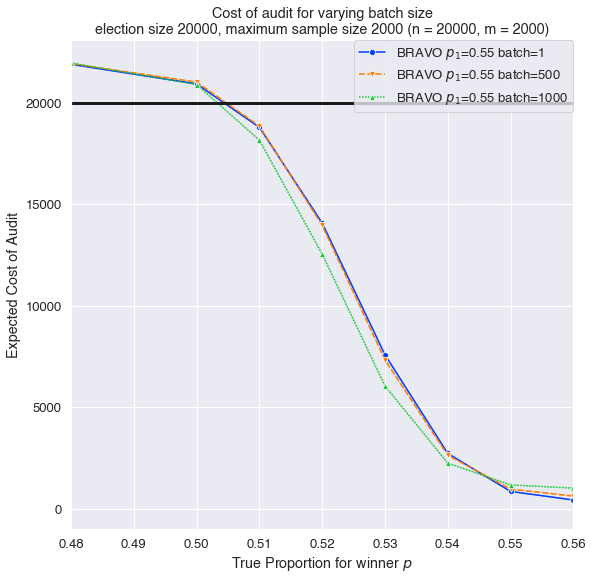

In [80]:
data_type = "unconditional_mean_with_recount.csv"
data = get_data(elections, data_type)
fig = plt.figure(figsize=[9, 9])
ax = fig.add_subplot(111)
sns.lineplot(
    x = 'p',
    y = 'value',
    hue = 'election_step',
    style= 'election_step',
    data=data,
    markers=filled_markers, 
    dashes=dash_styles,
    palette=sns.color_palette('bright', len(elections)), 
    legend=False, 
    ax=ax)
ax.axhline(20000, c='k', linewidth=3)
ax.set_title('Cost of audit for varying batch size\nelection size 20000, maximum sample size 2000 (n = 20000, m = 2000)')
ax.set_xlabel("True Proportion for winner $p$")
ax.set_ylabel("Expected Cost of Audit")
ax.set_xlim(0.48, 0.56)
make_legend(data, ax, borderaxespad=0., loc='upper right')